<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-решающего-дерева" data-toc-modified-id="Модель-решающего-дерева-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель решающего дерева</a></span></li><li><span><a href="#Модель-градиентного-бустинга" data-toc-modified-id="Модель-градиентного-бустинга-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель градиентного бустинга</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [23]:
conda install scklearn==1.2 #после этого необходимо рестартнуть ядро (Kernel->Restart the kernel)

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install phik -q
!pip install imblearn -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

from phik import phik_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

# загружаем классы для подготовки данных
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

# Constants
MAX_LAG = 24
ROLLING_MEAN_SIZE = 24
RANDOM_STATE = 12345

In [3]:
def get_var_name(var): #функция для получения имени переменной
    globals_dict = globals()
    return [name for name, value in globals_dict.items() if value is var][0]

def describe_dataset(dataset): #функция для описания данных в датасете
    display(dataset.head(5))
    print(f'Общие сведения о датасете {get_var_name(dataset)}')
    print('---------------------------------------------------------------------------')
    display(dataset.info())
    print(f'Пропуски в датасете {get_var_name(dataset)}')
    print('---------------------------------------------------------------------------')
    display(pd.DataFrame([round(dataset.isna().mean()*100), dataset.isna().sum()]).T.
    sort_values(by=0, ascending=False).
    rename(columns={0: 'Процент пропусков, %', 1: 'Количество пропусков'}).
    style.format("{:,.2f}").
    background_gradient('coolwarm').
    set_properties(**{'text-align': 'center'}))

## Подготовка

Загрузим данные

In [4]:
df = pd.read_csv("/datasets/taxi.csv",parse_dates =[0],index_col= 0)

In [5]:
describe_dataset(df)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Общие сведения о датасете df
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Пропуски в датасете df
---------------------------------------------------------------------------


,"Процент пропусков, %",Количество пропусков
num_orders,0.00,0.00


Видим, что данные не содержат пропусков. Записи сделаны для интервала 10 минут. Всего записей 26 496. 
Сгруппируем данные с интервалом в час, но предварительно проверим, что данные отсортированы в хронологическом порядке

In [6]:
df.index.is_monotonic

True

Данные отсортированы, можем приступать к ресэмплированию

In [7]:
df = df.resample("1H").sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Данные представлены за период с 1 марта 2018 по 31 августа 2018 года

**Вывод:** была произведена подготовка данных.
В датасете при выгрузке в качестве индекса была установлена дата, предоставленные данные отсортированы в хронологическом порядке
Данные предоставлены за период с 1 марта 2018 года по 31 августа 2018 года с интервалом 10 минут. Было выполнено ресэмплирование с интервалом в 1 час.

## Анализ

Рассмотрим данные 

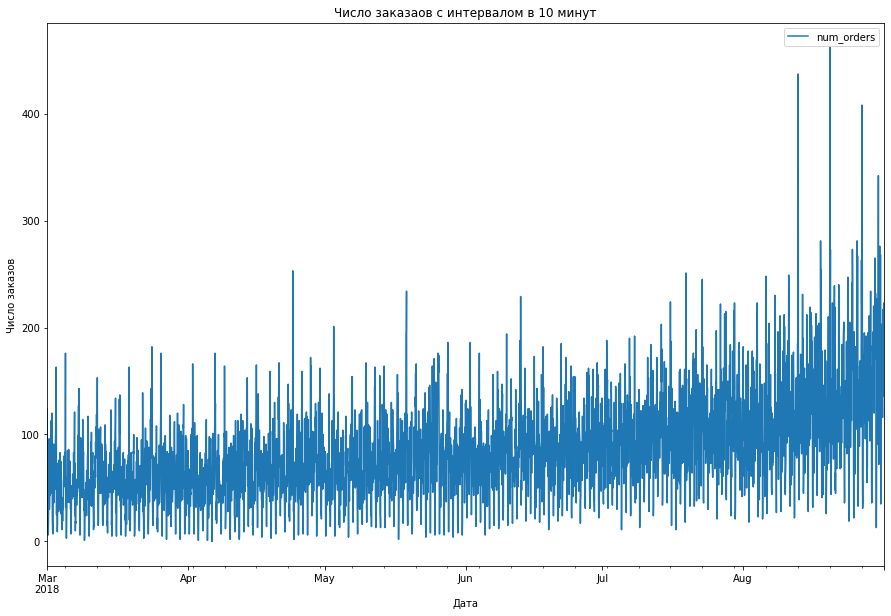

In [8]:
df.plot(figsize = (15,10), ylabel='Число заказов', xlabel='Дата', title='Число заказаов с интервалом в 10 минут');

Исследуем ряд на стационарность

Text(0.5, 1.0, 'Скользящее среднее и скользящее отклонение числа заказов')

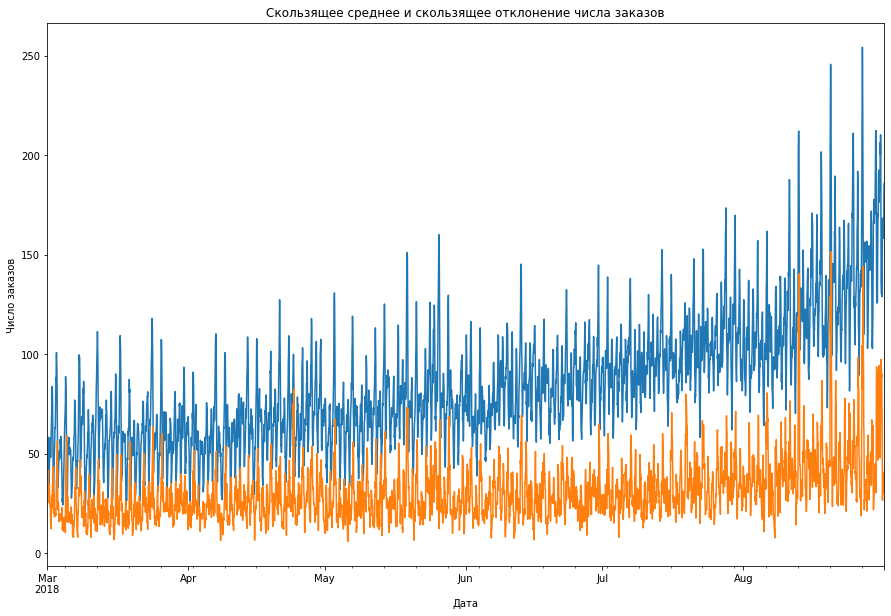

In [9]:
df['num_orders'].rolling(7).mean().plot(figsize = (15,10), ylabel='Число заказов', xlabel='Дата', label='mean');
df['num_orders'].rolling(7).std().plot(figsize = (15,10), ylabel='Число заказов', xlabel='Дата', label='std');
plt.title('Скользящее среднее и скользящее отклонение числа заказов')

Видим, что ряд явно не станционарный, так как его скользящее среднее и скользящее отклонение изменяются. Поэтому исследуем разность временного ряда с его смещением

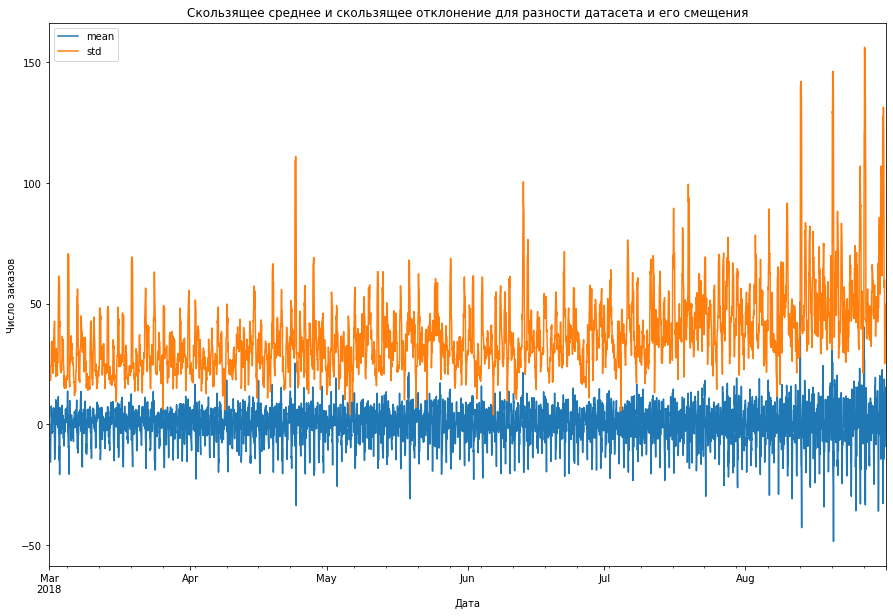

In [10]:
(df - df.shift())['num_orders'].rolling(7).mean().plot(figsize = (15,10), ylabel='Число заказов', xlabel='Дата', label='mean');
(df - df.shift())['num_orders'].rolling(7).std().plot(figsize = (15,10), ylabel='Число заказов', xlabel='Дата', label='std');
plt.title('Скользящее среднее и скользящее отклонение для разности датасета и его смещения')
plt.legend();

Такой датасет более стационарный, поэтому для исследования необходимо будет создать признак со смещением датасета

Исследуем данные на сезонность и тренд

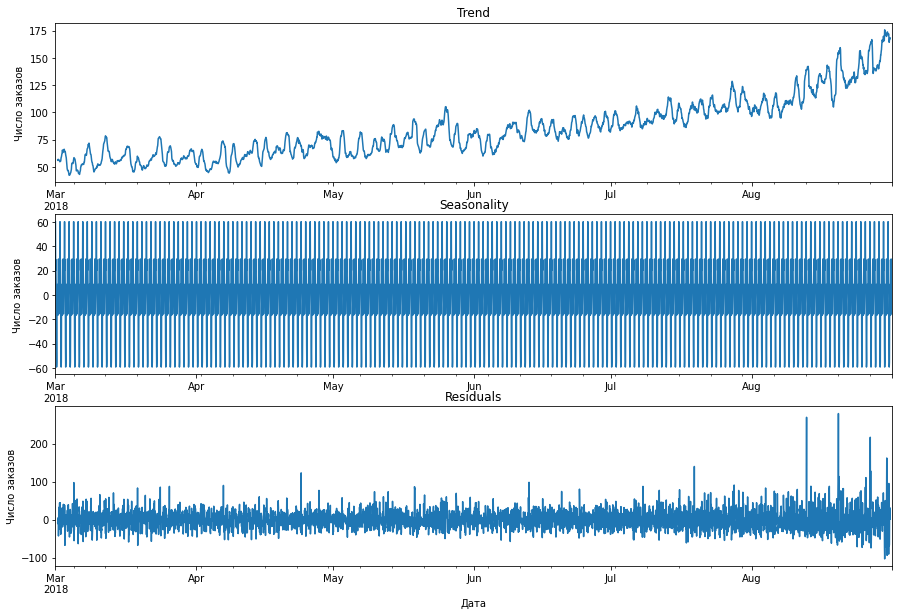

In [11]:
decomposed = seasonal_decompose(df["num_orders"])
fig,ax = plt.subplots(3,1,figsize = (15,10));

decomposed.trend.plot(ax=ax[0],title = 'Trend', ylabel='Число заказов', xlabel='Дата');
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality', ylabel='Число заказов', xlabel='Дата');
decomposed.resid.plot(ax=ax[2],title = 'Residuals', ylabel='Число заказов', xlabel='Дата');

Видим, что тренд на увеличение числа заказов. Возможно, это связано с наступлением летнего периода или с расширением бизнеса. Рассмотрим подробнее сезонность

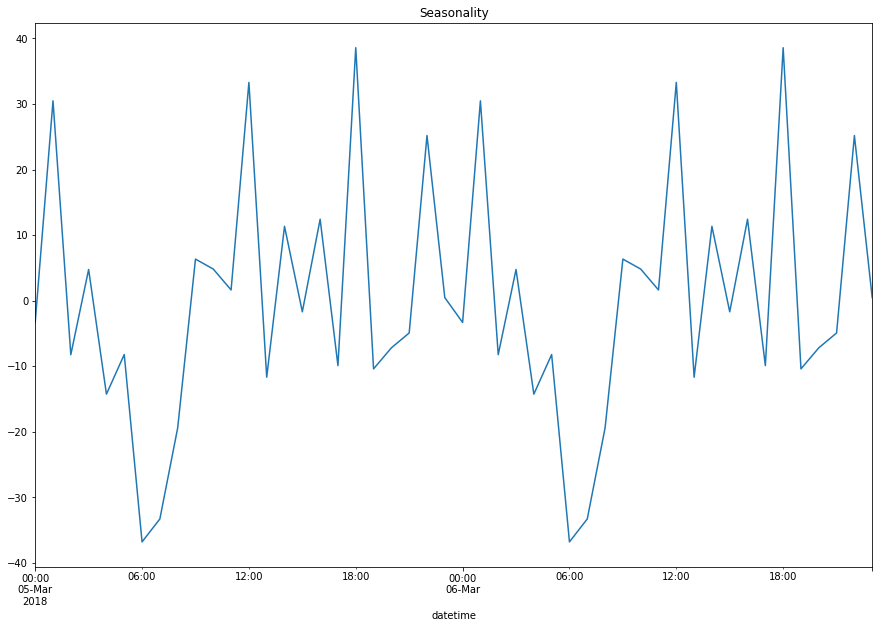

In [12]:
decomposed_short = seasonal_decompose(df["2018-03-05":"2018-03-06"]["num_orders"])
decomposed_short.seasonal.plot(title = 'Seasonality', figsize = (15,10));

Сезонность повторяется каждые сутки, т.е. ежедневно мы видим два пика - около 12:00 и около 18:00. К 6:00 наблюдается провал активности

**Вывод:**
Видим, тренд на увеличение числа заказов. Возможно, это связано с наступлением летнего периода или с расширением бизнеса. Период сезонности - сутки: ежедневно мы видим два пика - около 12:00 и около 18:00. К 6:00 наблюдается провал активности

## Обучение

Добавим новые признаки для обучения

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
make_features(df, MAX_LAG, ROLLING_MEAN_SIZE)
df.dropna(inplace=True)

In [15]:
display(df.head())

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


Разобьём датасет на обучающую и тестовую выборки

In [16]:
train, test = train_test_split(df, shuffle=False, random_state=RANDOM_STATE, test_size=0.1)

In [17]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']


In [18]:
X_train.columns

Index(['day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
       'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean'],
      dtype='object')

Построим пайплайны для предобработки данных и обучения

In [19]:
ohe_columns = [
    'day', 
    'dayofweek',
    'hour'
]
num_columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
              'lag_21', 'lag_22', 'lag_23', 'lag_24'] 

In [20]:
ohe_pipe = Pipeline(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
    )

In [21]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [22]:
pipe_final_DTR = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [23]:
pipe_final_LR = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [24]:
pipe_final_gbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', lgb.LGBMRegressor(random_state=RANDOM_STATE))
])

Перейдём к обучению моделей.  
Рассмотрим модель линейной регрессии, модель решающего дерева, а также модель LightGBM

### Модель линейной регрессии

In [31]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid_lr = [
    # словарь для модели DecisionTreeRegressor()

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler()],
    },
 
]

grid_lr = RandomizedSearchCV(
                          pipe_final_LR,
                          param_grid_lr,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv,
                          n_jobs=-1,
                          n_iter=50)
grid_lr.fit(X_train, y_train)
print('RMSE для модели линейной регрессии на тренировочных данных при кросс-валидации', abs(grid_lr.best_score_))

RMSE для модели линейной регрессии на тренировочных данных при кросс-валидации 25.874016399397288


### Модель решающего дерева

In [32]:
param_grid_DTR = [
    # словарь для модели DecisionTreeRegressor()

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None]+[i for i in range(1, 9)],
        'models__min_samples_leaf': range(1,6),
        'models__min_samples_split': range(2,6), 
        'preprocessor__num': ['passthrough'],
    },
 
]

grid_dtr = RandomizedSearchCV(
                          pipe_final_DTR,
                          param_grid_DTR,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv,
                          n_jobs=-1,
                          n_iter=50)
grid_dtr.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['day',
                                                                                'dayofweek',
                                                                                'hour']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['la...
                                                                                'lag_24'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=12345))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=12345)],
                                         'models__max_depth': [None, 1, 2, 3, 4,
                                                               5, 6, 7, 8],
                                         'models__min_samples_leaf': range(1, 6),
                                         'models__min_samples_split': range(2, 6),
                                         'preprocessor__num': ['passthrough']}],
                   scoring='neg_root_mean_squared_error')

In [33]:
print(grid_dtr.best_estimator_)
print('Метрика RMSE при кросс-валидации: ', abs(grid_dtr.best_score_))


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['day', 'dayofweek', 'hour']),
                                                 ('num', 'passthrough',
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_21', 'lag_22',
 

DecisionTreeRegressor(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                      random_state=12345)   
Метрика RMSE при кросс-валидации:  33.24187579872462

### Модель градиентного бустинга

In [37]:
param_grid_gbm = [
    # словарь для модели LightGBM

    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 500],
        'models__num_leaves': [280, 300, 320],
        'models__min_child_samples': [50, 100], 
        'models__reg_alpha': [0.5, 0.7],
        'preprocessor__num': [StandardScaler()],
    },
 
]

In [38]:
grid_gbm = RandomizedSearchCV(
                          pipe_final_gbm,
                          param_grid_gbm,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv,
                          n_jobs=-1,
                          n_iter=10)

grid_gbm.fit(X_train, y_train)


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['day',
                                                                                'dayofweek',
                                                                                'hour']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['la...
                                                                                'lag_24'])])),
                                             ('models',
                                              LGBMRegressor(random_state=12345))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LGBMRegressor(random_state=12345)],
                                         'models__min_child_samples': [50, 100],
                                         'models__n_estimators': [100, 500],
                                         'models__num_leaves': [280, 300, 320],
                                         'models__reg_alpha': [0.5, 0.7],
                                         'preprocessor__num': [StandardScaler()]}],
                   scoring='neg_root_mean_squared_error')

In [39]:
print(grid_gbm.best_estimator_)
print('Метрика RMSE при кросс-валидации: ', abs(grid_gbm.best_score_))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['day', 'dayofweek', 'hour']),
                                                 ('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_21', 'lag_22'

**Вывод:** были обучены три модели для прогнозирования временных рядов: линейная регрессия, дерево решений, градиентный бустинг LightGBM. Лучшей стала модель градиентого бустинга с параметрами min_child_samples=50, num_leaves=320, random_state=12345, reg_alpha=0.7 и метрика RMSE 25.51

## Тестирование

Проверим модель на тестовых данных 

In [40]:
best_model_gbm = grid_gbm.best_estimator_
lgbm_test_rmse = mean_squared_error(y_test, best_model_gbm.predict(X_test)) ** 0.5

In [41]:
print('RMSE на тестовых данных:', np.round(lgbm_test_rmse, 2))

RMSE на тестовых данных: 43.01


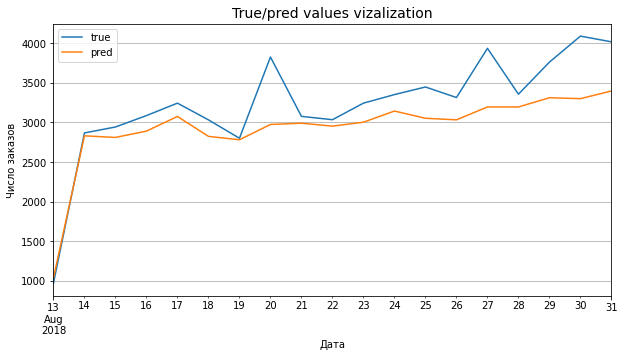

In [43]:
df_result = pd.DataFrame(y_test)
df_result['pred'] = np.round(best_model_gbm.predict(X_test), 4)
df_result.columns = ['true', 'pred']
df_result.resample('1D').sum().plot(figsize=(10, 5), grid=True, xlabel='Дата', ylabel='Число заказов')
plt.title('True/pred values vizalization', fontsize=14)
plt.show()

Сравним модель с dummy предсказанием по предыдущему значению ряда (тот же час с предыдущих суток)

In [44]:
pred_previous = y_test.shift(24)[24:]
print("RMSE:", mean_squared_error(y_test[24:], pred_previous) ** 0.5)

RMSE: 56.30034072174533


**Вывод:** модель обучена и протестирована на тестовых данных. RMSE = 36.67, что лучше простейшей dummy модели

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

# Вывод

В ходе проекта были выполнены:
1. Подготовка данных. В датасете при выгрузке в качестве индекса была установлена дата, предоставленные данные отсортированы в хронологическом порядке Данные предоставлены за период с 1 марта 2018 года по 31 августа 2018 года с интервалом 10 минут. Было выполнено ресэмплирование с интервалом в 1 час.
2. Анализ данных. Видим, тренд на увеличение числа заказов. Возможно, это связано с наступлением летнего периода или с расширением бизнеса. Период сезонности - сутки: ежедневно мы видим два пика - около 12:00 и около 18:00. К 6:00 наблюдается провал активности
3. были обучены четыре модели для прогнозирования временных рядов: линейная регрессия, дерево решений, градиентный бустинг LightGBM и градиентный бустинг CatBoost. Лучшей стала модель градиентого бустинга с параметрами LightGBM num_leaves=280 и метрика RMSE 30.09
4. На тестовых данных модель с указанными параметрами даёт результат RMSE=46.25